In [1]:
import numpy as np
from astropy.table import Table

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
from lsst.afw.math import Warper

import lsst.afw.geom as afwGeom



import lsst.geom as geom
import lsst.afw.image as afwImage

In [2]:
# Setup data id
tract, patch, filt = 4639, '0,0', 'r'
visit, detector = 181868, 57
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
deepCoadd_id = {'tract': tract, 'patch': patch, 'filter': filt}

In [3]:
calexp_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1'
calexp_butler = Butler(calexp_repo)
calexp_exposure = calexp_butler.get('calexp',  calexp_id)

In [4]:
template_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/coadd-dr1b-v1-grizy'
template_butler = Butler(template_repo)



In [5]:
template_exposure = template_butler.get('deepCoadd',  deepCoadd_id)

In [27]:
def filter_src(src_table):
    # This function filters out sources with flags.
    flag_list = ['base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
                'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
                'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
                'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_suspectCenter']

    row_num = []
    for num, src in enumerate(src_table):
        flag_count = 0
        for flag in flag_list:
            # Here is data type is np.bool_, not python's built-in bool
            if src[flag] is np.bool_(True):
                flag_count += 1
        if flag_count == 0:
            row_num.append(num)
    good_table = src_table[row_num]
    return good_table


"""
def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_NaiveCentroid_x']
            src_y = src['base_NaiveCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                count += 1
                break
        if count == 0:
            missed_list.append(i)
    return detected_list, missed_list
"""


In [8]:
mag_list = ['160','165','170','175','180','185','190','195','200','205','210','215','220','225','230','235','240']

In [6]:
check18_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check18_offset_25.txt',
                               format='ascii')
check20_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check20_offset_25.txt',
                               format='ascii')
check21_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check21_offset_25.txt',
                               format='ascii')
check22_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check22_offset_25.txt',
                               format='ascii')
check23_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check23_offset_25.txt',
                               format='ascii')
check24_offset = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check24_offset_25.txt',
                               format='ascii')

## check missing objects without applying flag cut

In [20]:
def make_cutout(exposure, x, y, cutout_size=60):
    # Make a cutout exposure at (x, y).
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def display_diff(diff_exposure, x, y, cutout_size=60, dia_list=None, scale=None, frame=None, title=None,
                save_name=None):
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(diff_exposure.getWcs().pixelToSky(x, y))
    cutout_image = diff_exposure.getCutout(radec, cutout_extent)
    
    xy = geom.PointI(x, y)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    # display.show_colorbar()
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    
    for coord in dia_list:
        coord_x, coord_y = coord
        display.dot('o', coord_x, coord_y, ctype='green')
        
    
    plt.title(title)
    if save_name:
        plt.savefig(save_name, dpi=500)
        
    


In [9]:
test_diff_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_18_offset/al_18_240_offset'
test_diff_buter = Butler(test_diff_repo)
test_src = test_diff_buter.get('deepDiff_diaSrc', calexp_id)
import re
test_astropy = test_src.asAstropy()
for i in test_astropy.columns:
    if re.search('_x', i, re.IGNORECASE):
        print(i)

base_NaiveCentroid_x
base_PeakCentroid_x
base_SdssCentroid_x
base_SdssCentroid_xErr
ip_diffim_NaiveDipoleCentroid_x
slot_Centroid_x
ip_diffim_NaiveDipoleCentroid_xErr
slot_Centroid_xErr
ip_diffim_NaiveDipoleCentroid_pos_x
slot_Centroid_pos_x
ip_diffim_NaiveDipoleCentroid_pos_xErr
slot_Centroid_pos_xErr
ip_diffim_NaiveDipoleCentroid_neg_x
slot_Centroid_neg_x
ip_diffim_NaiveDipoleCentroid_neg_xErr
slot_Centroid_neg_xErr
base_SdssShape_xx
slot_Shape_xx
base_SdssShape_xy
slot_Shape_xy
base_SdssShape_xxErr
slot_Shape_xxErr
base_SdssShape_xyErr
slot_Shape_xyErr
base_SdssShape_x
slot_Shape_x
base_SdssShape_psf_xx
slot_PsfShape_xx
slot_Shape_psf_xx
base_SdssShape_psf_xy
slot_PsfShape_xy
slot_Shape_psf_xy
base_SdssShape_instFlux_xx_Cov
slot_Shape_instFlux_xx_Cov
base_SdssShape_instFlux_xy_Cov
slot_Shape_instFlux_xy_Cov
ip_diffim_PsfDipoleFlux_pos_centroid_x
ip_diffim_PsfDipoleFlux_pos_centroid_xErr
ip_diffim_PsfDipoleFlux_neg_centroid_x
ip_diffim_PsfDipoleFlux_neg_centroid_xErr
ip_diffim_PsfDip

# check: 
- base_NaiveCentroid_x
- base_PeakCentroid_x
- base_SdssCentroid_x

## base_NaiveCentroid_x

In [24]:
def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        qualified_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_NaiveCentroid_x']
            src_y = src['base_NaiveCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                qualified_list.append((src_x, src_y))
                count += 1
        if count == 0:
            missed_list.append(i)
        dia_list.append(qualified_list)
    return detected_list, missed_list, dia_list

In [29]:
repo_20_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/al_20_180_offset'
detected_20_180, missed_20_180, dia_20_180 = check_detecion(repo_20_180, calexp_id, 'deepDiff_diaSrc',
                                                            check20_offset, half_side=17, filt_flag=False)

In [28]:
missed_20_180

[1, 7]

In [15]:
# calexp_20_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/fake_20_180_offset'
# calexp_20_180_buter = Butler(calexp_20_180_repo)
diff_20_180_buter = Butler(repo_20_180)
diff_20_180_exp = diff_20_180_buter.get('deepDiff_differenceExp', calexp_id)

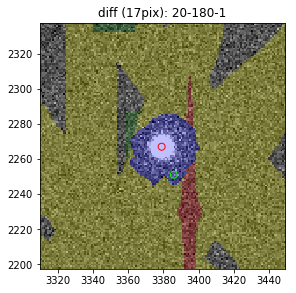

In [21]:
x, y = check20_offset[1]['base_NaiveCentroid_x'], check20_offset[1]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=140, dia_list=dia_20_180[1], title='diff (17pix): 20-180-1')

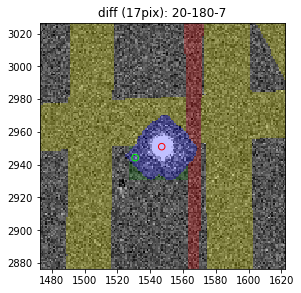

In [22]:
x, y = check20_offset[7]['base_NaiveCentroid_x'], check20_offset[7]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=150, dia_list=dia_20_180[7], title='diff (17pix): 20-180-7')

## base_PeakCentroid_x

In [22]:
def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        qualified_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_PeakCentroid_x']
            src_y = src['base_PeakCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                qualified_list.append((src_x, src_y))
                count += 1
        if count == 0:
            missed_list.append(i)
        dia_list.append(qualified_list)
    return detected_list, missed_list, dia_list

In [36]:
repo_20_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/al_20_180_offset'
detected_20_180, missed_20_180, dia_20_180 = check_detecion(repo_20_180, calexp_id, 'deepDiff_diaSrc',
                                                            check20_offset, half_side=17, filt_flag=False)

In [25]:
# calexp_20_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_20_offset/fake_20_180_offset'
# calexp_20_180_buter = Butler(calexp_20_180_repo)
diff_20_180_buter = Butler(repo_20_180)
diff_20_180_exp = diff_20_180_buter.get('deepDiff_differenceExp', calexp_id)

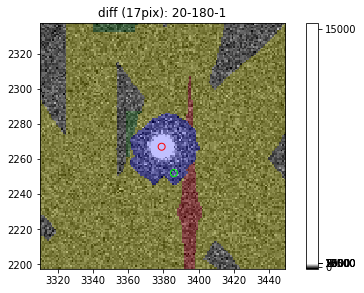

In [26]:
x, y = check20_offset[1]['base_NaiveCentroid_x'], check20_offset[1]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=140, dia_list=dia_20_180[1], title='diff (17pix): 20-180-1')

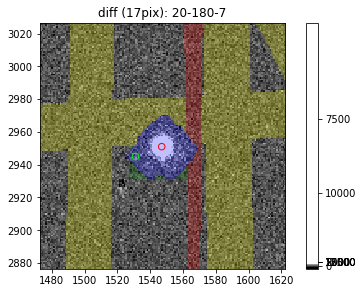

In [27]:
x, y = check20_offset[7]['base_NaiveCentroid_x'], check20_offset[7]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=150, dia_list=dia_20_180[7], title='diff (17pix): 20-180-7')

## base_SdssCentroid_x

In [44]:
def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        qualified_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_SdssCentroid_x']
            src_y = src['base_SdssCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                qualified_list.append((src_x, src_y))
                count += 1
        if count == 0:
            missed_list.append(i)
        dia_list.append(qualified_list)
    return detected_list, missed_list, dia_list

In [45]:
detected_20_180, missed_20_180, dia_20_180 = check_detecion(repo_20_180, calexp_id, 'deepDiff_diaSrc',
                                                            check20_offset, half_side=17, filt_flag=False)

In [46]:
missed_20_180

[]

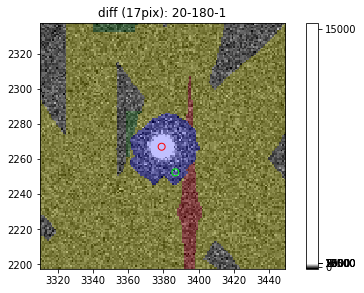

In [47]:
x, y = check20_offset[1]['base_NaiveCentroid_x'], check20_offset[1]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=140, dia_list=dia_20_180[1], title='diff (17pix): 20-180-1')

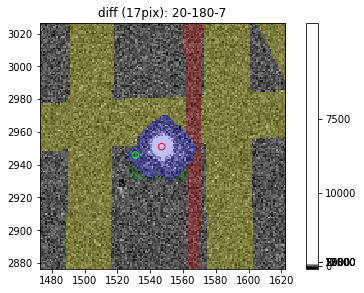

In [48]:
x, y = check20_offset[7]['base_NaiveCentroid_x'], check20_offset[7]['base_NaiveCentroid_y']
display_diff(diff_20_180_exp, x, y, cutout_size=150, dia_list=dia_20_180[7], title='diff (17pix): 20-180-7')

### check the row of the diaSrc

In [64]:
def get_detection_row(repo, data_id, table_type, check_table, half_side=4, filt_flag=True):
    detected_list = []
    missed_list = []
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        row_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_NaiveCentroid_x']
            src_y = src['base_NaiveCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_list.append(i)
                row_list.append(src)
                count += 1
        if count == 0:
            missed_list.append(i)
        dia_list.append(row_list)
    return detected_list, missed_list, dia_list

In [65]:
detected_20_180, missed_20_180, row_20_180 = get_detection_row(repo_20_180, calexp_id, 'deepDiff_diaSrc',
                                                            check20_offset, half_side=17, filt_flag=False)

In [85]:
idx = 1
injection_x, injection_y = check20_offset[idx]['base_NaiveCentroid_x'], check20_offset[idx]['base_NaiveCentroid_y']
cur_row = row_20_180[idx][0]
naive_x, naive_y = cur_row['base_NaiveCentroid_x'], cur_row['base_NaiveCentroid_y']
peak_x, peak_y = cur_row['base_PeakCentroid_x'], cur_row['base_PeakCentroid_y']
sdss_x, sdss_y = cur_row['base_SdssCentroid_x'], cur_row['base_SdssCentroid_y']
print('injection:')
print(f'injection x: {injection_x}, injection y: {injection_y}')
print('\n')
print('detection')
print(f'naive x: {naive_x}, naive y: {naive_y}')
print(f'peak x: {peak_x}, peak y: {peak_y}')
print(f'sdss x: {sdss_x}, sdss y: {sdss_y}')



injection:
injection x: 3379.0266095404404, injection y: 2267.0741260852787


detection
naive x: 3385.9403069195014, naive y: 2251.060553069901
peak x: 3386.0, peak y: 2252.0
sdss x: 3386.7853031297764, sdss y: 2252.418639819828


In [86]:
idx = 7
injection_x, injection_y = check20_offset[idx]['base_NaiveCentroid_x'], check20_offset[idx]['base_NaiveCentroid_y']
cur_row = row_20_180[idx][0]
naive_x, naive_y = cur_row['base_NaiveCentroid_x'], cur_row['base_NaiveCentroid_y']
peak_x, peak_y = cur_row['base_PeakCentroid_x'], cur_row['base_PeakCentroid_y']
sdss_x, sdss_y = cur_row['base_SdssCentroid_x'], cur_row['base_SdssCentroid_y']
print('injection:')
print(f'injection x: {injection_x}, injection y: {injection_y}')
print('\n')
print('detection')
print(f'naive x: {naive_x}, naive y: {naive_y}')
print(f'peak x: {peak_x}, peak y: {peak_y}')
print(f'sdss x: {sdss_x}, sdss y: {sdss_y}')

injection:
injection x: 1547.08265626288, injection y: 2951.184257241139


detection
naive x: 1530.7962612925016, naive y: 2944.3106996504016
peak x: 1531.0, peak y: 2945.0
sdss x: 1531.0025307549656, sdss y: 2945.9319423824372


# check peak position ?

### good row

In [87]:
idx = 0
injection_x, injection_y = check20_offset[idx]['base_NaiveCentroid_x'], check20_offset[idx]['base_NaiveCentroid_y']
cur_row = row_20_180[idx][0]
naive_x, naive_y = cur_row['base_NaiveCentroid_x'], cur_row['base_NaiveCentroid_y']
peak_x, peak_y = cur_row['base_PeakCentroid_x'], cur_row['base_PeakCentroid_y']
sdss_x, sdss_y = cur_row['base_SdssCentroid_x'], cur_row['base_SdssCentroid_y']
print('injection:')
print(f'injection x: {injection_x}, injection y: {injection_y}')
print('\n')
print('detection')
print(f'naive x: {naive_x}, naive y: {naive_y}')
print(f'peak x: {peak_x}, peak y: {peak_y}')
print(f'sdss x: {sdss_x}, sdss y: {sdss_y}')

injection:
injection x: 3349.030842175394, injection y: 1937.0949309182065


detection
naive x: 3349.004186302016, naive y: 1937.0169052058623
peak x: 3349.0, peak y: 1937.0
sdss x: 3349.0281498647805, sdss y: 1937.0874511398497


### 21 175

In [32]:
repo_21_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/al_21_175_offset'
detected_21_175, missed_21_175, dia_21_175 = check_detecion(repo_21_175, calexp_id, 'deepDiff_diaSrc',
                                                            check21_offset, half_side=18, filt_flag=False)

In [102]:
missed_21_175

[]

In [83]:
# [8, 9, 17]

In [34]:
diff_21_175_buter = Butler(repo_21_175)
diff_21_175_exp = diff_21_175_buter.get('deepDiff_differenceExp', calexp_id)
#calexp_21_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/fake_21_175_offset'
#calexp_21_175_buter = Butler(calexp_21_175_repo)

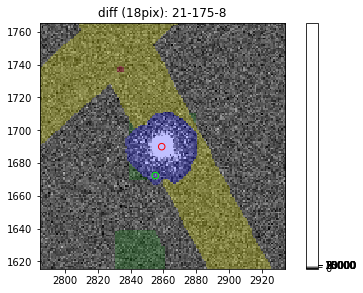

In [184]:
x, y = check21_offset[8]['base_NaiveCentroid_x'], check21_offset[8]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=150, dia_list=dia_21_175[8], title='diff (18pix): 21-175-8')

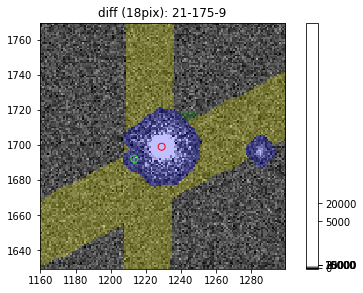

In [183]:
x, y = check21_offset[9]['base_NaiveCentroid_x'], check21_offset[9]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=140, dia_list=dia_21_175[9], title='diff (18pix): 21-175-9')

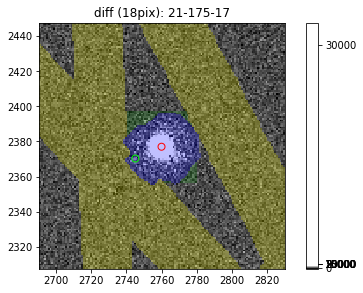

In [188]:
x, y = check21_offset[17]['base_NaiveCentroid_x'], check21_offset[17]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=140, dia_list=dia_21_175[17], title='diff (18pix): 21-175-17')

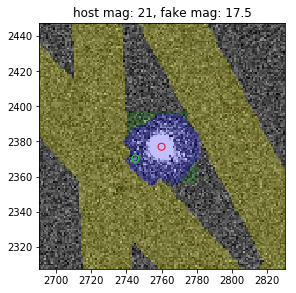

In [63]:
x, y = check21_offset[17]['base_NaiveCentroid_x'], check21_offset[17]['base_NaiveCentroid_y']
display_diff(diff_21_175_exp, x, y, cutout_size=140, dia_list=dia_21_175[17], title='host mag: 21, fake mag: 17.5',
            save_name='21-2.png')

## 21 180

In [137]:
repo_21_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/al_21_180_offset'
detected_21_180, missed_21_180, dia_21_180 = check_detecion(repo_21_180, calexp_id, 'deepDiff_diaSrc',
                                                            check21_offset, half_side=16, filt_flag=False)

In [138]:
missed_21_180

[]

In [139]:
# 6

In [133]:
diff_21_180_buter = Butler(repo_21_180)
diff_21_180_exp = diff_21_180_buter.get('deepDiff_differenceExp', calexp_id)
calexp_21_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_21_offset/fake_21_180_offset'
calexp_21_180_buter = Butler(calexp_21_180_repo)

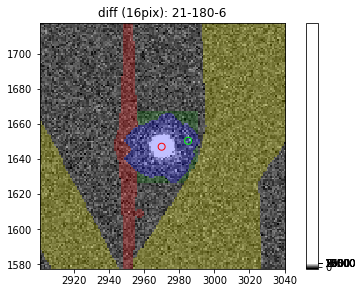

In [181]:
x, y = check21_offset[6]['base_NaiveCentroid_x'], check21_offset[6]['base_NaiveCentroid_y']
display_diff(diff_21_180_exp, x, y, cutout_size=140, dia_list=dia_21_180[6], title='diff (16pix): 21-180-6')

# 22 175, two objects

In [37]:
repo_22_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/al_22_175_offset'
detected_22_175, missed_22_175, dia_22_175 = check_detecion(repo_22_175, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=47, filt_flag=False)



In [38]:
missed_22_175

[]

In [146]:
# 2, 6

In [39]:
diff_22_175_buter = Butler(repo_22_175)
diff_22_175_exp = diff_22_175_buter.get('deepDiff_differenceExp', calexp_id)
# calexp_22_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/fake_22_175_offset'
# calexp_22_175_buter = Butler(calexp_22_175_repo)

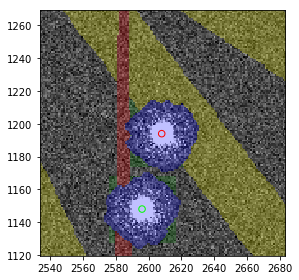

In [62]:
x, y = check22_offset[2]['base_NaiveCentroid_x'], check22_offset[2]['base_NaiveCentroid_y']
display_diff(diff_22_175_exp, x, y, cutout_size=150, dia_list=dia_22_175[2], title='diff (47pix): 22-175-2')

In [ ]:
x, y = check22_offset[2]['base_NaiveCentroid_x'], check22_offset[2]['base_NaiveCentroid_y']
display_diff(diff_22_175_exp, x, y, cutout_size=150, dia_list=dia_22_175[2], title='diff (47pix): 22-175-2')

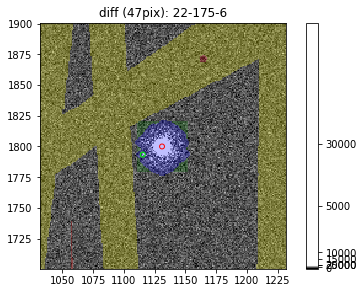

In [177]:
x, y = check22_offset[6]['base_NaiveCentroid_x'], check22_offset[6]['base_NaiveCentroid_y']
display_diff(diff_22_175_exp, x, y, cutout_size=200, dia_list=dia_22_175[6], title='diff (47pix): 22-175-6')

In [360]:

!pwd

/global/u1/s/shl159/fake_injection


### 22 185

In [72]:
repo_22_185  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/al_22_185_offset'
detected_22_185, missed_22_185, dia_22_185 = check_detecion(repo_22_185, calexp_id, 'deepDiff_diaSrc',
                                                check22_offset, half_side=10, filt_flag=False)


In [73]:
diff_22_185_buter = Butler(repo_22_185)
diff_22_185_exp = diff_22_185_buter.get('deepDiff_differenceExp', calexp_id)
calexp_22_185_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_22_offset/fake_22_185_offset'
calexp_22_185_buter = Butler(calexp_22_185_repo)

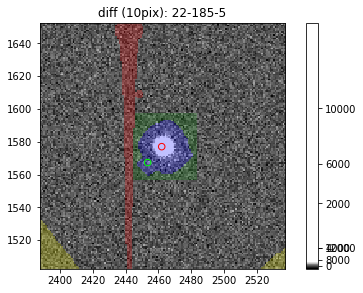

In [179]:
x, y = check22_offset[5]['base_NaiveCentroid_x'], check22_offset[5]['base_NaiveCentroid_y']
display_diff(diff_22_185_exp, x, y, cutout_size=150, dia_list=dia_22_185[5], title='diff (10pix): 22-185-5')

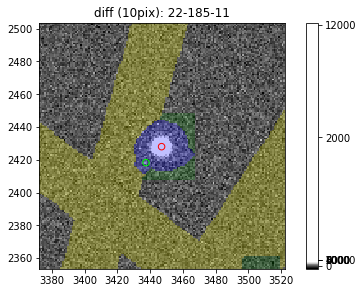

In [190]:
x, y = check22_offset[11]['base_NaiveCentroid_x'], check22_offset[11]['base_NaiveCentroid_y']
display_diff(diff_22_185_exp, x, y, cutout_size=150, dia_list=dia_22_185[11], title='diff (10pix): 22-185-11')

## 23 - 175

In [207]:
repo_23_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/al_23_175_offset'
detected_23_175, missed_23_175, dia_23_175 = check_detecion(repo_23_175, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=16, filt_flag=False)

In [208]:
missed_23_175

[]

In [211]:
# 7

In [214]:
diff_23_175_buter = Butler(repo_23_175)
diff_23_175_exp = diff_23_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_23_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/fake_23_175_offset'
calexp_23_175_buter = Butler(calexp_23_175_repo)

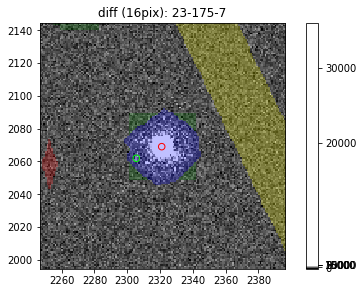

In [216]:
x, y = check23_offset[7]['base_NaiveCentroid_x'], check23_offset[7]['base_NaiveCentroid_y']
display_diff(diff_23_175_exp, x, y, cutout_size=150, dia_list=dia_23_175[7], title='diff (16pix): 23-175-7')

## 23 180

In [41]:
repo_23_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/al_23_180_offset'
detected_23_180, missed_23_180, dia_23_180 = check_detecion(repo_23_180, calexp_id, 'deepDiff_diaSrc',
                                                check23_offset, half_side=16, filt_flag=False)

In [233]:
missed_23_180

[]

In [231]:
# [0, 14]

In [42]:
diff_23_180_buter = Butler(repo_23_180)
diff_23_180_exp = diff_23_180_buter.get('deepDiff_differenceExp', calexp_id)
# calexp_23_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_23_offset/fake_23_180_offset'
# calexp_23_180_buter = Butler(calexp_23_180_repo)

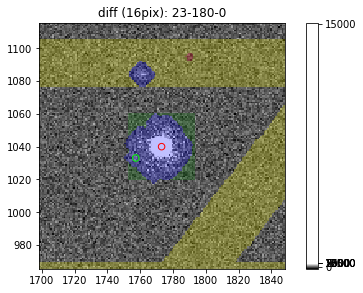

In [236]:
x, y = check23_offset[0]['base_NaiveCentroid_x'], check23_offset[0]['base_NaiveCentroid_y']
display_diff(diff_23_180_exp, x, y, cutout_size=150, dia_list=dia_23_180[0], title='diff (16pix): 23-180-0')

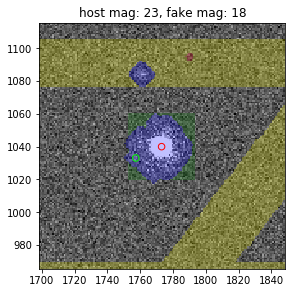

In [43]:
x, y = check23_offset[0]['base_NaiveCentroid_x'], check23_offset[0]['base_NaiveCentroid_y']
display_diff(diff_23_180_exp, x, y, cutout_size=150, dia_list=dia_23_180[0], title='host mag: 23, fake mag: 18',
            save_name='23.png')

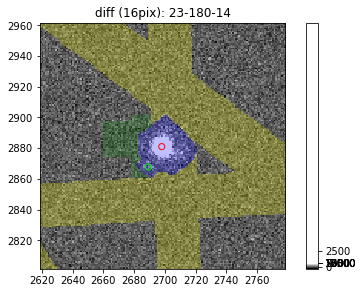

In [238]:
x, y = check23_offset[14]['base_NaiveCentroid_x'], check23_offset[14]['base_NaiveCentroid_y']
display_diff(diff_23_180_exp, x, y, cutout_size=160, dia_list=dia_23_180[14], title='diff (16pix): 23-180-14')

## 24 175

In [256]:
repo_24_175  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_175_offset'
detected_24_175, missed_24_175, dia_24_175 = check_detecion(repo_24_175, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=16, filt_flag=False)

In [257]:
missed_24_175

[]

In [241]:
# 3

In [258]:
diff_24_175_buter = Butler(repo_24_175)
diff_24_175_exp = diff_24_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_24_175_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_175_offset'
calexp_24_175_buter = Butler(calexp_24_175_repo)

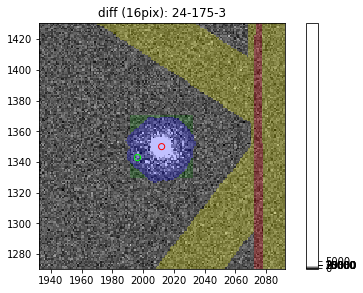

In [260]:
x, y = check24_offset[3]['base_NaiveCentroid_x'], check24_offset[3]['base_NaiveCentroid_y']
display_diff(diff_24_175_exp, x, y, cutout_size=160, dia_list=dia_24_175[3], title='diff (16pix): 24-175-3')

## 24 - 180

In [44]:
repo_24_180  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_180_offset'
detected_24_180, missed_24_180, dia_24_180 = check_detecion(repo_24_180, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=16, filt_flag=False)

In [45]:
missed_24_180

[]

In [46]:
## [5, 11]

In [47]:
diff_24_180_buter = Butler(repo_24_180)
diff_24_180_exp = diff_24_175_buter.get('deepDiff_differenceExp', calexp_id)
calexp_24_180_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_180_offset'
calexp_24_180_buter = Butler(calexp_24_180_repo)

NameError: name 'diff_24_175_buter' is not defined

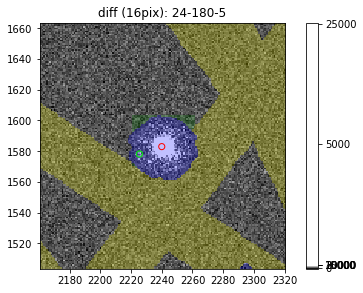

In [281]:
x, y = check24_offset[5]['base_NaiveCentroid_x'], check24_offset[5]['base_NaiveCentroid_y']
display_diff(diff_24_180_exp, x, y, cutout_size=160, dia_list=dia_24_180[5], title='diff (16pix): 24-180-5')

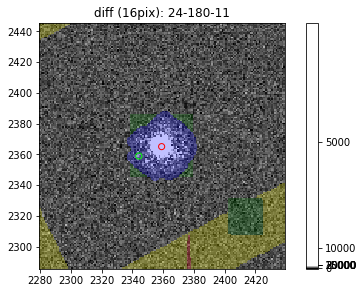

In [282]:
x, y = check24_offset[11]['base_NaiveCentroid_x'], check24_offset[11]['base_NaiveCentroid_y']
display_diff(diff_24_180_exp, x, y, cutout_size=160, dia_list=dia_24_180[11], title='diff (16pix): 24-180-11')

## 24 185

In [54]:
repo_24_185  = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/al_24_185_offset'
detected_24_185, missed_24_185, dia_24_185 = check_detecion(repo_24_185, calexp_id, 'deepDiff_diaSrc',
                                                check24_offset, half_side=11, filt_flag=False)

In [55]:
missed_24_185

[]

In [56]:
# 10

In [58]:
diff_24_185_buter = Butler(repo_24_185)
diff_24_185_exp = diff_24_185_buter.get('deepDiff_differenceExp', calexp_id)
# calexp_24_185_repo = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/fake_data/fake_offset_25_poisson/fake_24_offset/fake_24_185_offset'
# calexp_24_185_buter = Butler(calexp_24_185_repo)

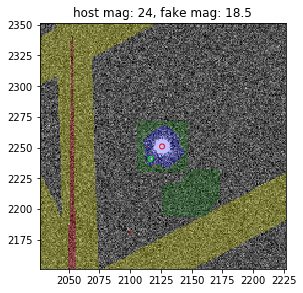

In [59]:
x, y = check24_offset[10]['base_NaiveCentroid_x'], check24_offset[10]['base_NaiveCentroid_y']
display_diff(diff_24_185_exp, x, y, cutout_size=200, dia_list=dia_24_185[10], title='host mag: 24, fake mag: 18.5',
            save_name='24.png')

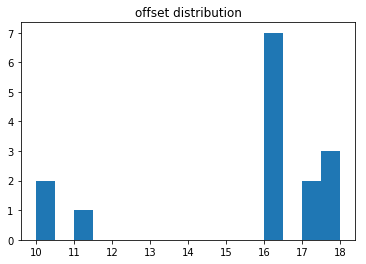

In [358]:
distance = np.array([17, 17, 18, 18, 18, 16, 10, 10, 16, 16, 16, 16, 16, 16, 11])
plt.hist(distance, bins=16)
plt.title('offset distribution')
print()

#### Almost all of these missing objects come from the shifting of the detected position from the injection position. Only one missing source comes from the adjacency to another source（22 175.  Could this shifting issue stems from the bright pixel of the Poisson fluctuation (run injection of the perfect model, check maximum position)?

#### I also need to check the poststamps of the missing objects at the high magnitude tail.

possible configs

doDecorrelation, convolveTemplate (AL, ZOGY)
doSpatiallyVarying, doPreconvolve (just AL?)
